In [1]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
from torch import nn
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np



device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", device)

# ------------------
# 1. Define CourseEncoder (same as in training)
# ------------------
class CourseEncoder(nn.Module):
    def __init__(self, base_model_name="bert-base-uncased", proj_dim=256):
        super().__init__()
        self.bert = AutoModel.from_pretrained(base_model_name)
        hidden = self.bert.config.hidden_size
        self.proj = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, proj_dim),
        )

    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls = out.last_hidden_state[:, 0, :]        # CLS
        z = self.proj(cls)
        z = nn.functional.normalize(z, p=2, dim=-1) # for cosine
        return z

# ------------------
# 2. Load data
# ------------------
df = pd.read_csv("../data/cleaned_courses.csv")
texts = df["TextForBERT"].astype(str).tolist()
print("N texts:", len(texts))

# ------------------
# 3. Vanilla BERT
# ------------------
vanilla_name = "bert-base-uncased"
tok_v = AutoTokenizer.from_pretrained(vanilla_name)
model_v = AutoModel.from_pretrained(vanilla_name).to(device)
model_v.eval()

# ------------------
# 4. Trained contrastive model
# ------------------

#trained_dir = "course_encoder_contrastive"
trained_dir = "model_v6_temp_0.75"

tok_t = AutoTokenizer.from_pretrained(trained_dir)

model_t = CourseEncoder(base_model_name="bert-base-uncased", proj_dim=256)
state = torch.load(f"{trained_dir}/pytorch_model.bin", map_location=device)
model_t.load_state_dict(state)
model_t.to(device)
model_t.eval()

/home/tony/ELG5255/Project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using: cuda
N texts: 518


CourseEncoder(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

In [2]:
import numpy as np
import torch
import torch.nn.functional as F
from transformers import PreTrainedModel

def embed_texts(texts, tokenizer, model, batch_size=32, max_len=64):
    all_embs = []
    model.eval()

    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            enc = tokenizer(
                batch,
                padding=True,
                truncation=True,
                max_length=max_len,
                return_tensors="pt"
            ).to(device)

            # HF model (vanilla BERT)
            if isinstance(model, PreTrainedModel):
                out = model(**enc)  # BaseModelOutput
                cls = out.last_hidden_state[:, 0, :]          # [CLS]
                embs = F.normalize(cls, p=2, dim=-1)          # (batch, hidden)
            else:
                # Your CourseEncoder already returns normalized embeddings
                embs = model(
                    input_ids=enc["input_ids"],
                    attention_mask=enc["attention_mask"],
                )

            all_embs.append(embs.cpu().numpy())

    return np.vstack(all_embs)


In [3]:
emb_v = embed_texts(texts, tok_v, model_v)  # vanilla BERT
emb_t = embed_texts(texts, tok_t, model_t)  # contrastive encoder

print("Vanilla embeddings:", emb_v.shape)
print("Trained embeddings:", emb_t.shape)

Vanilla embeddings: (518, 768)
Trained embeddings: (518, 256)



Vanilla BERT
Mean cosine: 0.8160411
Std  cosine: 0.053145144


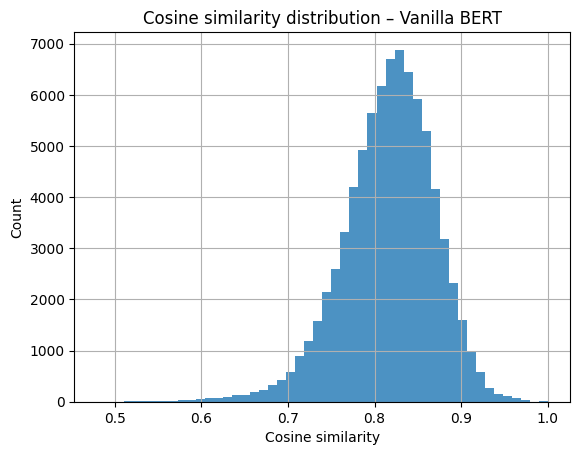


Fine-tuned BERT
Mean cosine: 0.30495057
Std  cosine: 0.15615809


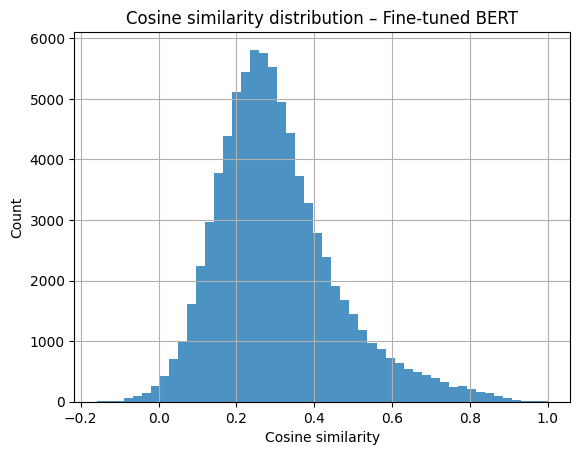

In [4]:
def cosine_stats_and_plot(emb, label):
    n = min(400, emb.shape[0])
    sub = emb[:n]

    sims = cosine_similarity(sub, sub)
    iu = np.triu_indices_from(sims, k=1)
    vals = sims[iu]

    print(f"\n{label}")
    print("Mean cosine:", vals.mean())
    print("Std  cosine:", vals.std())

    plt.hist(vals, bins=50, alpha=0.8)
    plt.title(f"Cosine similarity distribution – {label}")
    plt.xlabel("Cosine similarity")
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()

cosine_stats_and_plot(emb_v, "Vanilla BERT")
cosine_stats_and_plot(emb_t, "Fine-tuned BERT")


In [5]:
import umap

reducer_v = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    random_state=42,
)
emb_v_umap = reducer_v.fit_transform(emb_v)

reducer_t = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    random_state=42,
)
emb_t_umap = reducer_t.fit_transform(emb_t)

/home/tony/ELG5255/Project/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/tony/ELG5255/Project/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [6]:

from output import get_top_n_recommendations, print_recommendations

df_s = pd.read_csv("../data/students_clean_train.csv")

print(df_s.columns)

texts_s = df_s["StudentText"].astype(str).tolist()
len(texts), texts_s[0][:200]

embeddings_s = embed_texts(texts_s, tok_t, model_t)
print(embeddings_s.shape)  # (num_students, 256)


student_index = 4
student_emb = embeddings_s[student_index]
liked_str = df_s.loc[student_index, "LikedCourses"]


top_df = get_top_n_recommendations(
    student_emb=student_emb,
    course_embs=emb_t,
    course_df=df,
    top_n=5,
)
print_recommendations(top_df)

Index(['StudentText', 'LikedCourses'], dtype='object')
(480, 256)

Top 5 recommended courses:

86. ELG 6127 [similarity: 0.7260]
   Title: Distributed Systems Engineering 
   Desc : Techniques for representing distributed systems: graphical and textual models. Processes, threads, synchronization and inter-process communication techniques, RPC. Middleware: client-server (CORBA), grids, Web services. Resource management: processor allocation, load sharing, Grid scheduling, real-time issues. Protocol: OSI model, application and presentation layers. This course is equivalent to SYSC 5207 at Carleton University.

167. CEG 4198 [similarity: 0.7097]
   Title: Distributed Systems Design 
   Desc : Hardware/software architectures for distributed computing environments. Design issues for distributed systems and distributed computing. Protocols for process communications. Time and coordination; algorithms. Design of distributed systems memory; shared memory. Replication mechanisms and architectur

In [7]:
student_umap = reducer_t.transform(student_emb.reshape(1, -1))
top_indices = top_df.index.to_numpy()

/tmp/ipykernel_44913/2168051521.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(unique_prefixes))


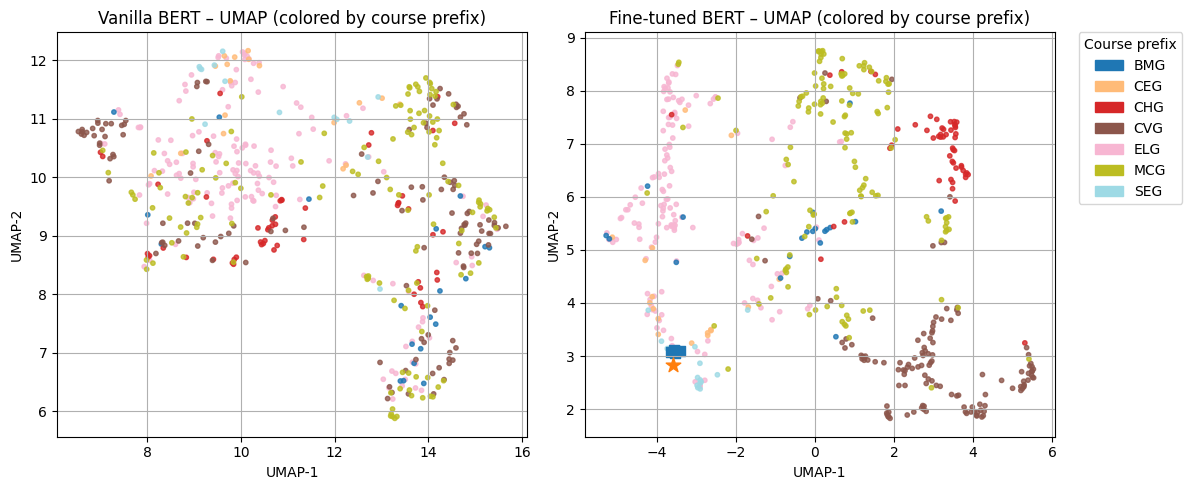

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Build prefixes and colors
prefixes = df["Faculty"].str.extract(r"([A-Za-z]+)")[0]
unique_prefixes = sorted(prefixes.unique())
mapping = {p: i for i, p in enumerate(unique_prefixes)}
colors = prefixes.map(mapping).values

# UMAP embeddings already computed: emb_v_umap, emb_t_umap

cmap = plt.cm.get_cmap('tab20', len(unique_prefixes))

plt.figure(figsize=(12, 5))

# Vanilla
plt.subplot(1, 2, 1)
plt.scatter(
    emb_v_umap[:, 0],
    emb_v_umap[:, 1],
    s=10,
    c=colors,
    cmap=cmap,
    alpha=0.8,
)
plt.title("Vanilla BERT – UMAP (colored by course prefix)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)

# Fine-tuned
plt.subplot(1, 2, 2)
plt.scatter(
    emb_t_umap[:, 0],
    emb_t_umap[:, 1],
    s=10,
    c=colors,
    cmap=cmap,
    alpha=0.8,
)

# highlight the student's top-N recommended courses
plt.scatter(
    emb_t_umap[top_indices, 0],
    emb_t_umap[top_indices, 1],
    s=60,
    marker="s",
)

# highlight the student embedding
plt.scatter(
    student_umap[0, 0],
    student_umap[0, 1],
    s=120,
    marker="*",
)

plt.title("Fine-tuned BERT – UMAP (colored by course prefix)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)

# Shared legend
handles = [
    mpatches.Patch(color=cmap(mapping[p]), label=p)
    for p in unique_prefixes
]

plt.legend(
    handles=handles,
    title="Course prefix",
    bbox_to_anchor=(1.05, 1.0),
    loc="upper left",
    borderaxespad=0.0,
)
plt.tight_layout()
plt.show()

In [9]:
from IsoScore.IsoScore import IsoScore

vanila_bert_iso_score = IsoScore(emb_v)
tuned_bert_iso_score = IsoScore(emb_t)

print(f"Vanilla Bert Isotropy score: {vanila_bert_iso_score}")
print(f"Tuned Bert Isotropy score: {tuned_bert_iso_score}")

Vanilla Bert Isotropy score: 0.02486410364508629
Tuned Bert Isotropy score: 0.09603151679039001
